In [112]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score








In [113]:

df = pd.read_csv("Data/instagram_data.csv")
df.isnull().sum()  # Check missing values
df.fillna(0, inplace=True)  # Replace NaNs with 0 if applicable
df = df[df['verified'] != 1]


In [114]:
print(df.head())

                user_id               name  posts followers following    PVT  \
0         ronaldo.prime       Cristiano 🐐🙌  1,844      124K       403  False   
1             cristiano  Cristiano Ronaldo  3,831      649M       594  False   
2  ronaldo_cr7_fan_____               cr 7    131     54.6K         7  False   
3               ronaldo            Ronaldo  1,497     29.5M     2,913  False   
4         cr_7.ronalddo       Ronaldo cr.7      5       114        11  False   

     date_joined  former_usernames  verified  
0  November 2020              3.00         0  
1       May 2012              0.00         1  
2    August 2022              4.00         0  
3      June 2011              0.00         1  
4  November 2021              3.00         0  


In [115]:
df['date_joined'] = pd.to_datetime(df['date_joined'].astype(str) + "-01", format="%B %Y-%d", errors='coerce')
df['account_age'] = (pd.Timestamp.now() - df['date_joined']).dt.days

In [116]:
print(df.head())

                user_id               name  posts followers following    PVT  \
0         ronaldo.prime       Cristiano 🐐🙌  1,844      124K       403  False   
1             cristiano  Cristiano Ronaldo  3,831      649M       594  False   
2  ronaldo_cr7_fan_____               cr 7    131     54.6K         7  False   
3               ronaldo            Ronaldo  1,497     29.5M     2,913  False   
4         cr_7.ronalddo       Ronaldo cr.7      5       114        11  False   

  date_joined  former_usernames  verified  account_age  
0  2020-11-01              3.00         0         1562  
1  2012-05-01              0.00         1         4668  
2  2022-08-01              4.00         0          924  
3  2011-06-01              0.00         1         5003  
4  2021-11-01              3.00         0         1197  


In [117]:
def convert_k_notation(value):
    if pd.isna(value):
        return 0
    value = str(value).replace(',', '')
    value = str(value).replace('.', '')
    if 'K' in value:
        return int(float(value.replace('K', '')) * 1000)
    if 'M' in value:
        return int(float(value.replace('M', '')) * 1000000)
    return int(value)

df['followers'] = df['followers'].apply(convert_k_notation)
df['following'] = df['following'].apply(convert_k_notation)

### **Step 3: Convert Private/Public (PVT) to Binary**
df['PVT'] = df['PVT'].astype(bool).astype(int)  # False → 0 (Public), True → 1 (Private)

#  F/F Ratio
df['followers_following_ratio'] = (df['followers'] + 1) / (df['following'] + 1)

df['posts'] = pd.to_numeric(df['posts'], errors='coerce')

df['is_low_activity'] = df['posts'] < 3
df['is_high_activity'] = df['posts'] > 5000

# Display processed data
print(df.head())

                user_id               name  posts  followers  following  PVT  \
0         ronaldo.prime       Cristiano 🐐🙌    NaN     124000        403    0   
1             cristiano  Cristiano Ronaldo    NaN  649000000        594    0   
2  ronaldo_cr7_fan_____               cr 7 131.00     546000          7    0   
3               ronaldo            Ronaldo    NaN  295000000       2913    0   
4         cr_7.ronalddo       Ronaldo cr.7   5.00        114         11    0   

  date_joined  former_usernames  verified  account_age  \
0  2020-11-01              3.00         0         1562   
1  2012-05-01              0.00         1         4668   
2  2022-08-01              4.00         0          924   
3  2011-06-01              0.00         1         5003   
4  2021-11-01              3.00         0         1197   

   followers_following_ratio  is_low_activity  is_high_activity  
0                     306.93            False             False  
1                 1090756.30          

In [118]:
def detect_fake_username(user_id):
    if re.search(r'\d{5,}', user_id):  # More than 5 consecutive numbers
        return 1
    if re.search(r'(.)\1{2,}', user_id):  # Repeated letters (aaa, 111)
        return 1
    if len(user_id) < 3:  # Too short
        return 1
    return 0

df['user_id'] = df['user_id'].astype(str)

df['fake_username'] = df['user_id'].apply(detect_fake_username)


In [119]:
def detect_fake_name(name):
    if len(name) < 3 or len(name) > 25:
        return 1
    if re.search(r'[^\w\s]', name):  # Special characters
        return 1
    return 0

df['name'] = df['name'].astype(str)


df['fake_name'] = df['name'].apply(detect_fake_name)

In [120]:
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Select string (categorical) columns
string_df = df.select_dtypes(include=[object])

# Display the first few rows of each DataFrame
print("Numeric DataFrame:")
print(numeric_df.head())

print("\nString DataFrame:")
print(string_df.head())

Numeric DataFrame:
   posts  followers  following  PVT  former_usernames  verified  account_age  \
0    NaN     124000        403    0              3.00         0         1562   
1    NaN  649000000        594    0              0.00         1         4668   
2 131.00     546000          7    0              4.00         0          924   
3    NaN  295000000       2913    0              0.00         1         5003   
4   5.00        114         11    0              3.00         0         1197   

   followers_following_ratio  fake_username  fake_name  
0                     306.93              0          1  
1                 1090756.30              0          0  
2                   68250.12              1          0  
3                  101235.42              0          0  
4                       9.58              0          1  

String DataFrame:
                user_id               name
0         ronaldo.prime       Cristiano 🐐🙌
1             cristiano  Cristiano Ronaldo
2  ronaldo

In [121]:
pd.options.display.float_format = '{:.2f}'.format
print("MEAN \n")
print(numeric_df.mean())
print("MEDIAN")
print(numeric_df.median())
print("MODE")
print(numeric_df.mode().iloc[0])
print("STD")
print(numeric_df.std())


MEAN 

posts                            207.38
followers                   18196377.08
following                        638.94
PVT                                0.17
former_usernames                   1.31
verified                           0.36
account_age                     2516.22
followers_following_ratio    1732119.92
fake_username                      0.07
fake_name                          0.28
dtype: float64
MEDIAN
posts                        100.00
followers                   6477.50
following                    321.00
PVT                            0.00
former_usernames               0.00
verified                       0.00
account_age                 2612.50
followers_following_ratio     39.23
fake_username                  0.00
fake_name                      0.00
dtype: float64
MODE
posts                            0.00
followers                   388000.00
following                        1.00
PVT                              0.00
former_usernames                 0.00
v

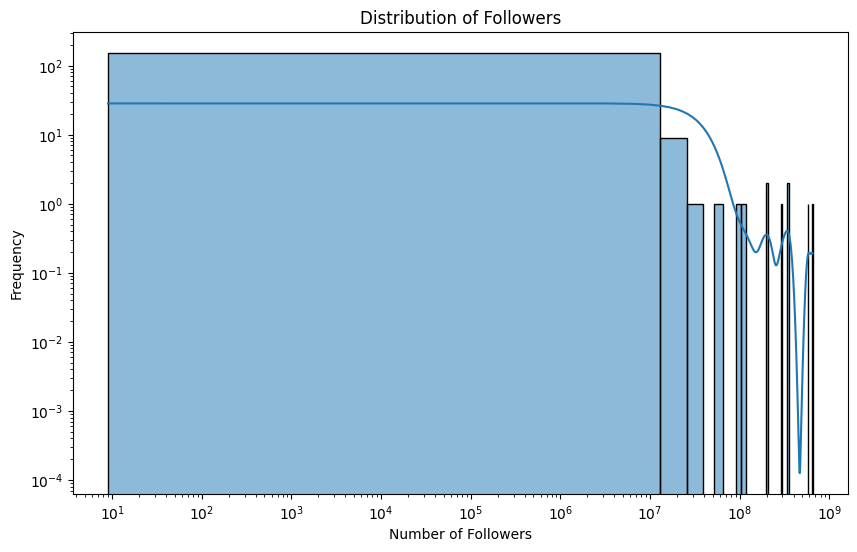

In [122]:
plt.figure(figsize=(10, 6))
sns.histplot(df['followers'], bins=50, kde=True)
plt.title('Distribution of Followers')
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.xscale('log')  # Use a logarithmic scale for the x-axis
plt.yscale('log')  # Optionally, use a logarithmic scale for the y-axis
plt.show()

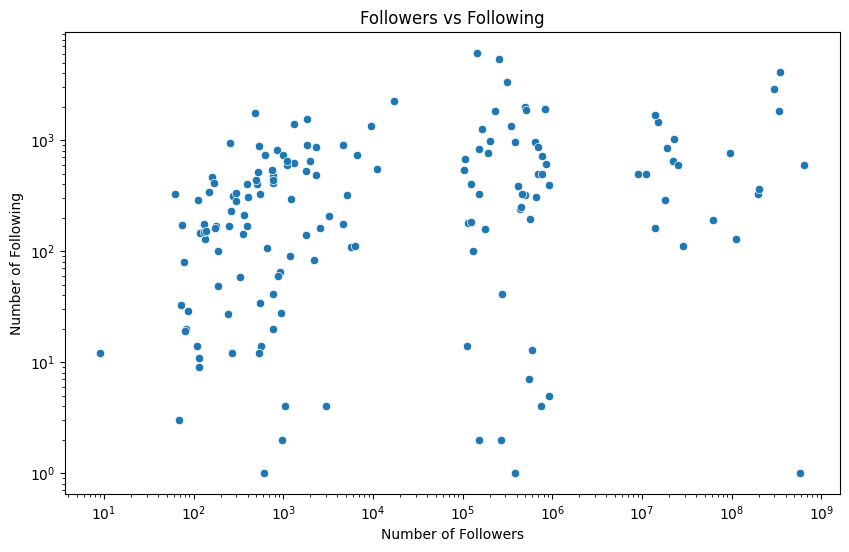

In [123]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='followers', y='following', data=df)
plt.title('Followers vs Following')
plt.xlabel('Number of Followers')
plt.ylabel('Number of Following')
plt.xscale('log')  # Use a logarithmic scale for the x-axis
plt.yscale('log')  # Optionally, use a logarithmic scale for the y-axis
plt.show()

In [124]:
# Ensure the necessary columns are numeric
df['followers'] = pd.to_numeric(df['followers'], errors='coerce')
df['following'] = pd.to_numeric(df['following'], errors='coerce')

# Drop rows with NaN values in the selected columns
df.dropna(subset=['followers', 'following'], inplace=True)

# Apply logarithm transformation to the data
df['log_followers'] = np.log1p(df['followers'])  # log1p is used to handle log(0)
df['log_following'] = np.log1p(df['following'])

# Prepare the data for clustering
X_log = df[['log_followers', 'log_following']].values

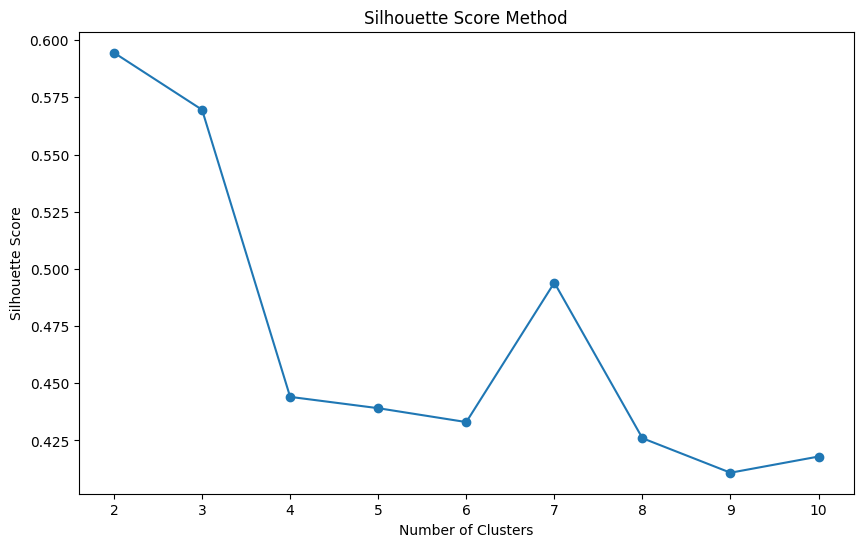

In [125]:
# Calculate silhouette scores for different values of n_clusters
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=50)
    kmeans.fit(X_log)
    score = silhouette_score(X_log, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [126]:
# Determine the optimal number of clusters using the Elbow Method or Silhouette Score
optimal_clusters = 3  # Replace with the chosen number of clusters based on the methods above

# Fit the K-Means model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_log)

# Calculate the distance to the nearest cluster center
df['distance_to_center'] = np.min(kmeans.transform(X_log), axis=1)

# Identify outliers based on the distance to the nearest cluster center
threshold = np.percentile(df['distance_to_center'], 90)  # Adjust the percentile as needed
df['is_outlier'] = df['distance_to_center'] > threshold

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                user_id               name  posts  followers  following  PVT  \
0         ronaldo.prime       Cristiano 🐐🙌    NaN     124000        403    0   
1             cristiano  Cristiano Ronaldo    NaN  649000000        594    0   
2  ronaldo_cr7_fan_____               cr 7 131.00     546000          7    0   
3               ronaldo            Ronaldo    NaN  295000000       2913    0   
4         cr_7.ronalddo       Ronaldo cr.7   5.00        114         11    0   

  date_joined  former_usernames  verified  account_age  \
0  2020-11-01              3.00         0         1562   
1  2012-05-01              0.00         1         4668   
2  2022-08-01              4.00         0          924   
3  2011-06-01              0.00         1         5003   
4  2021-11-01              3.00         0         1197   

   followers_following_ratio  is_low_activity  is_high_activity  \
0                     306.93            False             False   
1                 1090756.30        

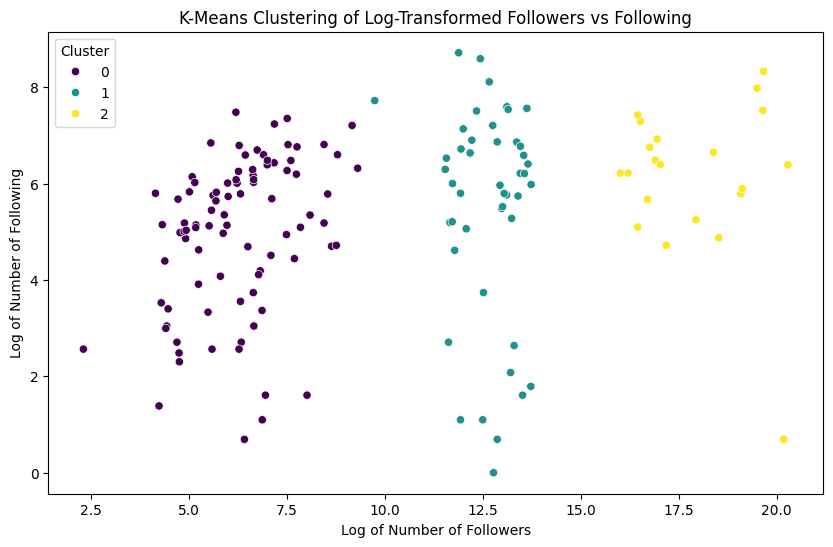

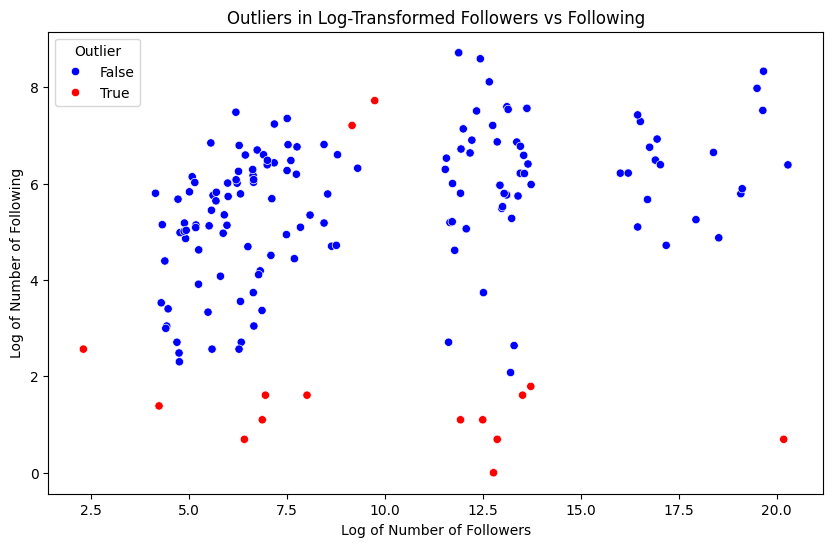

In [127]:
# Plot the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_followers', y='log_following', hue='cluster', palette='viridis', data=df, legend='full')
plt.title('K-Means Clustering of Log-Transformed Followers vs Following')
plt.xlabel('Log of Number of Followers')
plt.ylabel('Log of Number of Following')
plt.legend(title='Cluster')
plt.show()

# Plot the outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_followers', y='log_following', hue='is_outlier', palette={False: 'blue', True: 'red'}, data=df, legend='full')
plt.title('Outliers in Log-Transformed Followers vs Following')
plt.xlabel('Log of Number of Followers')
plt.ylabel('Log of Number of Following')
plt.legend(title='Outlier')
plt.show()

In [128]:
# Filter the DataFrame to get the outlier accounts
outlier_accounts = df[df['is_outlier']]

# Display the outlier accounts
print(outlier_accounts)

                   user_id                               name  posts  \
11           abigail_lutz3                       Abigail Lutz 127.00   
19            abbiecornish                      Abbie Cornish 269.00   
24   abbeys_playset_rental             Abbeys Play Set Rental    NaN   
32            abbiecornish                      Abbie Cornish 269.00   
47           abigail_lutz3                       Abigail Lutz 127.00   
52           abigail_lutz3                       Abigail Lutz 127.00   
67            gautam.adani                       Gautam Adani  54.00   
71           adah_ki_radha                       Radha Sharma 582.00   
80          adarahofficial                       ADARAH INDIA 704.00   
96             _adel_brand  Одежда |Мини Цех | Бишкек| Ателье 108.00   
98                   adele                              Adele 508.00   
110          adelebabegirl                                  0 303.00   
123          smtsudhamurty                   Smt. Sudha Murty 26

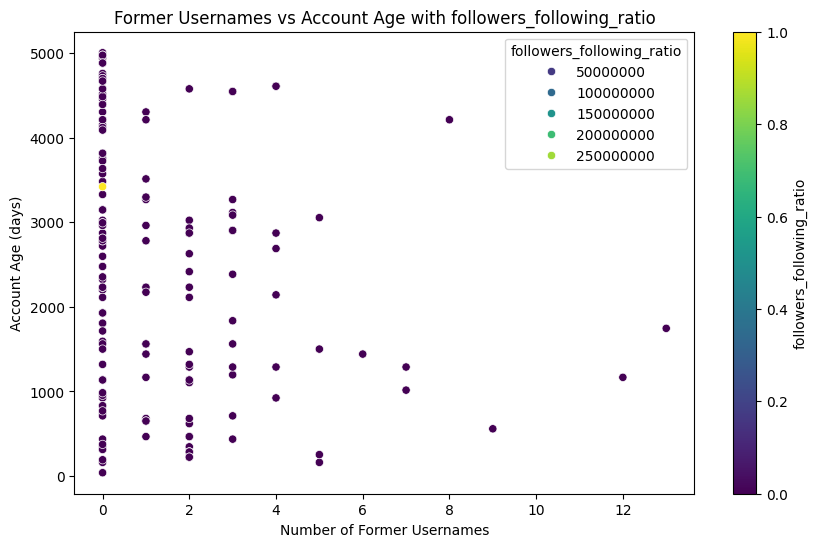

In [129]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='former_usernames', y='account_age', hue='followers_following_ratio', palette='viridis', data=df)
plt.title('Former Usernames vs Account Age with followers_following_ratio')
plt.xlabel('Number of Former Usernames')
plt.ylabel('Account Age (days)')
plt.colorbar(scatter.collections[0], label='followers_following_ratio')
plt.show()

In [130]:
features = ['followers_following_ratio', 'is_low_activity', 'is_high_activity', 'fake_username', 'fake_name']
X = df[features]
y = df['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

KeyError: 'is_fake'

In [ ]:
# Fit the IsolationForest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Assume 5% of accounts are fake
df['fake_score'] = iso_forest.fit_predict(df[['posts', 'followers', 'following', 'followers_following_ratio']])

# Filter the DataFrame to get the outliers
df_fake_accounts = df[df['fake_score'] == -1]  # -1 indicates anomaly

# Display the outliers
print(df_fake_accounts)

In [ ]:
# Plot a scatter plot to visualize the outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='followers', y='following', hue='fake_score', palette={1: 'blue', -1: 'red'}, data=df)
plt.title('Followers vs Following with Outliers')
plt.xlabel('Number of Followers')
plt.ylabel('Number of Following')
plt.legend(title='Fake Score', loc='upper right', labels=['Normal', 'Outlier'])
plt.show()

In [ ]:
# Plot a pair plot to visualize the outliers
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='fake_score', palette={1: 'blue', -1: 'red'})
plt.suptitle('Pair Plot of Features with Outliers', y=1.02)
plt.show()